# Create probes

activate npx...

In [19]:
# listen to changes
%load_ext autoreload
%autoreload 2

import os
from collections import Counter

# set project path
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023/"

os.chdir(PROJ_PATH)

from time import time
from matplotlib import pyplot as plt
import pandas as pd
from src.nodes.dataeng.silico.filtering import filter_microcircuit_cells
from src.nodes.load import load_campaign_params
from src.nodes.study.layer import getAtlasInfo

# SETUP PARAMETERS
from src.nodes.utils import get_config
EXPERIMENT = "silico_neuropixels"   # specifies the experiment 
SIMULATION_DATE = "2023_10_18"      # specifies the run (date)
data_conf, param_conf = get_config(EXPERIMENT, SIMULATION_DATE).values()
WIRED_PATH = data_conf["probe_wiring"]["output"]

# SETUP PROBE PARAMETERS
N_COLS = 4
N_CONTACT_PER_COL = 32
X_PITCH = 22.5
Y_PITCH = 22.5
STAGGER = 0
SHAPE = "square"
WIDTH = 20

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-03-14 18:00:51,560 - root - utils.py - get_config - INFO - Reading experiment config.
2024-03-14 18:00:51,588 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Describe probe geometry

In [6]:
# calculate other geometrical features
# 4 rows separated by 16 microns
shank_width = (4 - 1) * X_PITCH
print("probe shank width (center to center):", shank_width, "microns")

# calculate measures on illustrator figures
# 12.46 mm <-> 460 microns wide cortical column
print("shank width (center to center):", shank_width * 12.46 / 460, "mm")
print("electrode size:", WIDTH * 12.46 / 460, "mm")
print("x-pitch and y-pitch:", X_PITCH * 12.46 / 460, "mm")

probe shank width (center to center): 67.5 microns
shank width (center to center): 1.8283695652173915 mm
electrode size: 0.5417391304347826 mm
x-pitch and y-pitch: 0.6094565217391305 mm


### Create probe

In [10]:
import bluepy as bp
from probeinterface import generate_multi_columns_probe
from sklearn.decomposition import PCA
import numpy as np


def create_horvath_probe_depth_1(
    path_to_blueconfig: str,
    n_cols: int = 4,
    n_contact_per_col: int = 32,
    x_pitch: float = 22.5,
    y_pitch: float = 22.5,
    stagger: float = 0,
    shape: str = "square",
    width: float = 20,
):
    # create 2d probeinterface probe object
    CenteredProbe = generate_multi_columns_probe(
        num_columns=n_cols,
        num_contact_per_column=n_contact_per_col,
        xpitch=x_pitch,
        ypitch=y_pitch,
        y_shift_per_column=[0, stagger, 0, stagger],
        contact_shapes=shape,
        contact_shape_params={"width": width},
    )

    # make 3D
    Probe = CenteredProbe.to_3d()

    # center probe at (0,0,0)
    # - align probe with yz plane
    # - center probe's z axis too at 0
    Probe.rotate(90, axis=[0, 0, 1])
    Probe.move(
        np.array(
            [-(X_PITCH * (N_COLS - 1)) / 2, 0, -(Y_PITCH * (N_CONTACT_PER_COL - 1)) / 2]
        )
    )

    # get the campaign parameters from one of the simulation
    # get the microcircuit (hex_01) cells to position the probe at its centroid
    # calculate circuit's centroid by averaging of cell soma coordinates
    simulation = bp.Simulation(path_to_blueconfig)
    circuit = simulation.circuit
    soma_location = circuit.cells.get(
        {"$target": "hex_O1"}, properties=[bp.Cell.X, bp.Cell.Y, bp.Cell.Z]
    )
    circuit_centroid = np.mean(soma_location, axis=0).values

    # rotate and center probe to circuit center
    pca = PCA(n_components=3)
    pca.fit(soma_location)
    main_axis = pca.components_[0]
    elevation = np.arctan2(np.sqrt(main_axis[0] ** 2 + main_axis[1] ** 2), main_axis[2])
    azimuth = np.arctan2(main_axis[1], main_axis[0])
    Probe.rotate(elevation * 180 / np.pi, axis=[0, 1, 0])
    Probe.rotate(azimuth * 180 / np.pi, axis=[0, 0, 1])
    Probe.move(circuit_centroid)

    # position the probe at depth 2 that mimics
    # the layer coverage of Horvath probe at depth 2
    # rotate around circuit/probe center then translate it
    SHIFT_FROM_CENTER_1 = main_axis * 850
    Probe.rotate(0.62 * 180 / np.pi, axis=[0, 1, 0])
    Probe.rotate(0.2 * azimuth * 180 / np.pi, axis=[0, 0, 1])
    Probe.move(SHIFT_FROM_CENTER_1)
    return Probe


def create_horvath_probe_depth_2(
    path_to_blueconfig: str,
    n_cols: int = 4,
    n_contact_per_col: int = 32,
    x_pitch: float = 22.5,
    y_pitch: float = 22.5,
    stagger: float = 0,
    shape: str = "square",
    width: float = 20,
):
    # create 2d probeinterface probe object
    CenteredProbe = generate_multi_columns_probe(
        num_columns=n_cols,
        num_contact_per_column=n_contact_per_col,
        xpitch=x_pitch,
        ypitch=y_pitch,
        y_shift_per_column=[0, stagger, 0, stagger],
        contact_shapes=shape,
        contact_shape_params={"width": width},
    )

    # make 3D
    Probe = CenteredProbe.to_3d()

    # center probe at (0,0,0)
    # - align probe with yz plane
    # - center probe's z axis too at 0
    Probe.rotate(90, axis=[0, 0, 1])
    Probe.move(
        np.array(
            [-(X_PITCH * (N_COLS - 1)) / 2, 0, -(Y_PITCH * (N_CONTACT_PER_COL - 1)) / 2]
        )
    )

    # get the campaign parameters from one of the simulation
    # get the microcircuit (hex_01) cells to position the probe at its centroid
    # calculate circuit's centroid by averaging of cell soma coordinates
    simulation = bp.Simulation(path_to_blueconfig)
    circuit = simulation.circuit
    soma_location = circuit.cells.get(
        {"$target": "hex_O1"}, properties=[bp.Cell.X, bp.Cell.Y, bp.Cell.Z]
    )
    circuit_centroid = np.mean(soma_location, axis=0).values

    # rotate and center probe to circuit center
    pca = PCA(n_components=3)
    pca.fit(soma_location)
    main_axis = pca.components_[0]
    elevation = np.arctan2(np.sqrt(main_axis[0] ** 2 + main_axis[1] ** 2), main_axis[2])
    azimuth = np.arctan2(main_axis[1], main_axis[0])
    Probe.rotate(elevation * 180 / np.pi, axis=[0, 1, 0])
    Probe.rotate(azimuth * 180 / np.pi, axis=[0, 0, 1])
    Probe.move(circuit_centroid)

    # rotate at center then translate
    SHIFT_FROM_CENTER_1 = main_axis * 850
    SHIFT_FROM_DEPTH_1 = -main_axis * 800
    Probe.move(SHIFT_FROM_CENTER_1 + SHIFT_FROM_DEPTH_1)
    return Probe


def create_horvath_probe_depth_3(
    path_to_blueconfig: str,
    n_cols: int = 4,
    n_contact_per_col: int = 32,
    x_pitch: float = 22.5,
    y_pitch: float = 22.5,
    stagger: float = 0,
    shape: str = "square",
    width: float = 20,
):
    # create 2D ProbeInterface probe object
    CenteredProbe = generate_multi_columns_probe(
        num_columns=N_COLS,
        num_contact_per_column=N_CONTACT_PER_COL,
        xpitch=X_PITCH,
        ypitch=Y_PITCH,
        y_shift_per_column=[0, STAGGER, 0, STAGGER],
        contact_shapes=SHAPE,
        contact_shape_params={"width": WIDTH},
    )

    # make 3D
    Probe = CenteredProbe.to_3d()

    # center probe at (0,0,0)
    # - align probe with yz plane
    # - center probe's z axis at 0
    Probe.rotate(90, axis=[0, 0, 1])
    Probe.move(
        np.array(
            [-(X_PITCH * (N_COLS - 1)) / 2, 0, -(Y_PITCH * (N_CONTACT_PER_COL - 1)) / 2]
        )
    )

    # get the campaign parameters from one of the simulation
    # get the microcircuit (hex_01) cells to position the probe at its centroid
    # calculate circuit's centroid by averaging of cell soma coordinates
    simulation = bp.Simulation(path_to_blueconfig)
    circuit = simulation.circuit
    soma_location = circuit.cells.get(
        {"$target": "hex_O1"}, properties=[bp.Cell.X, bp.Cell.Y, bp.Cell.Z]
    )
    circuit_centroid = np.mean(soma_location, axis=0).values

    # rotate and center probe to circuit center
    pca = PCA(n_components=3)
    pca.fit(soma_location)
    main_axis = pca.components_[0]
    elevation = np.arctan2(np.sqrt(main_axis[0] ** 2 + main_axis[1] ** 2), main_axis[2])
    azimuth = np.arctan2(main_axis[1], main_axis[0])
    Probe.rotate(elevation * 180 / np.pi, axis=[0, 1, 0])
    Probe.rotate(azimuth * 180 / np.pi, axis=[0, 0, 1])
    Probe.move(circuit_centroid)

    # rotate at center then translate along probe axis
    SHIFT_FROM_CENTER_1 = main_axis * 850
    SHIFT_FROM_DEPTH_1 = -main_axis * 800
    SHIFT_FROM_DEPTH_2 = -main_axis * 1000
    Probe.move(SHIFT_FROM_CENTER_1 + SHIFT_FROM_DEPTH_1 + SHIFT_FROM_DEPTH_2)
    return Probe


# Create Horvath probe at depth 1
HorvathProbe1 = create_horvath_probe_depth_1(
    path_to_blueconfig="/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/raw/neuropixels_lfp_10m_384ch_hex0_40Khz_2023_10_18/be011315-9555-493e-a59c-27f42d1058ed/0/BlueConfig",
)

# Create Horvath probe at depth 2
HorvathProbe2 = create_horvath_probe_depth_2(
    path_to_blueconfig="/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/raw/neuropixels_lfp_10m_384ch_hex0_40Khz_2023_10_18/be011315-9555-493e-a59c-27f42d1058ed/0/BlueConfig",
)

# Create Horvath probe at depth 3
HorvathProbe3 = create_horvath_probe_depth_3(
    path_to_blueconfig="/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/raw/neuropixels_lfp_10m_384ch_hex0_40Khz_2023_10_18/be011315-9555-493e-a59c-27f42d1058ed/0/BlueConfig",
)

### Check layer coverage

- should replicate as best as possible experimental coverage {' L2/3': 60, ' L1': 36, ' Outside of the cortex': 32}

Counter({'L2/3': 64, 'L1': 37, 'Outside': 27})
Counter({'L5': 88, 'L4': 32, 'L2/3': 8})
Counter({'L6': 76, 'Outside': 52})


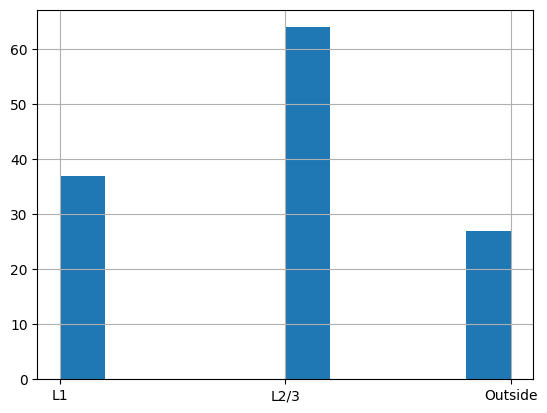

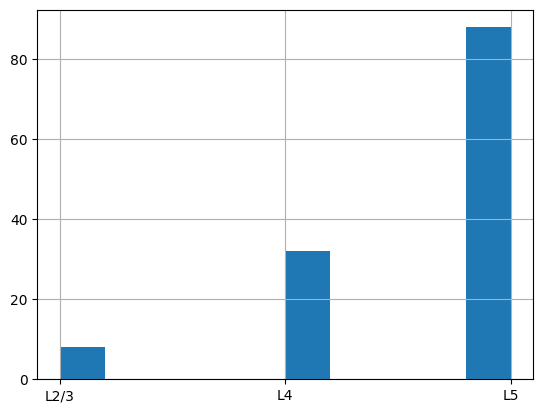

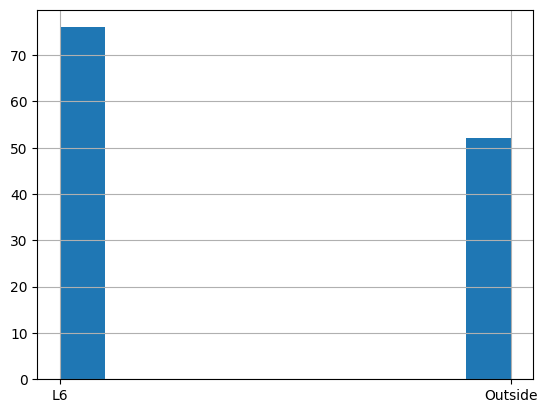

In [18]:
# PROBE 1 ---------

# report layers covered
out = getAtlasInfo(data_conf["dataeng"]["blueconfig"], HorvathProbe1.contact_positions)

# electrodes per site
# - merge layers 2 and 3
plt.figure()
location_1 = pd.Series(out[1]).sort_values()
location_1[location_1 == "L2"] = "L2/3"
location_1[location_1 == "L3"] = "L2/3"
location_1.hist()
print(Counter(location_1))

# PROBE 2 ---------

# report layers covered
out = getAtlasInfo(data_conf["dataeng"]["blueconfig"], HorvathProbe2.contact_positions)

# electrodes per site
# - merge layers 2 and 3
plt.figure()
location_2 = pd.Series(out[1]).sort_values()
location_2[location_2 == "L2"] = "L2/3"
location_2[location_2 == "L3"] = "L2/3"
location_2.hist()
print(Counter(location_2))


# PROBE 3 ---------

# report layers covered
out = getAtlasInfo(data_conf["dataeng"]["blueconfig"], HorvathProbe3.contact_positions)

# electrodes per site
# - merge layers 2 and 3
plt.figure()
location_3 = pd.Series(out[1]).sort_values()
location_3[location_3 == "L2"] = "L2/3"
location_3[location_3 == "L3"] = "L2/3"
location_3.hist()
print(Counter(location_3))

### plot

In [ ]:
simulation = load_campaign_params(data_conf)
microcircuit = filter_microcircuit_cells(simulation)
microcircuit_coord = microcircuit["soma_location"].sample(
    n=1000, axis=0, random_state=1
)
cell_layers = simulation["circuit"].cells.get(
    group=microcircuit["gid"], properties="layer"
)
layers = np.sort(cell_layers.unique())
fig = plt.figure(figsize=(20, 20))

# setup plot
ax = fig.add_subplot(111, projection="3d")
ax.view_init(90, 0, 0)
layer_color = [
    (0, 0, 0),
    (213 / 255, 62 / 255, 79 / 255),
    (252 / 255, 141 / 255, 89 / 255),
    (254 / 255, 224 / 255, 139 / 255),
    (230 / 255, 245 / 255, 152 / 255),
    (153 / 255, 213 / 255, 148 / 255),
    (50 / 255, 136 / 255, 189 / 255),
]

for layer_i in layers:
    ax.plot(
        microcircuit_coord.x[cell_layers == layer_i],
        microcircuit_coord.y[cell_layers == layer_i],
        ".",
        color=layer_color[int(layer_i)],
        markersize=12,
    )

# add contacts
ax.plot(
    HorvathProbe1.contact_positions[:, 0],
    HorvathProbe1.contact_positions[:, 1],
    marker=".",
    markersize=12,
    color="y",
    markeredgecolor="black",
    linestyle="None",
)
legend = ax.legend(layers, fontsize=12, title="Layers")

In [ ]:
fig = plt.figure(figsize=(20, 20))

# setup plot
ax = fig.add_subplot(111, projection="3d")
ax.view_init(90, 0, 0)

for layer_i in layers:
    ax.plot(
        microcircuit_coord.x[cell_layers == layer_i],
        microcircuit_coord.y[cell_layers == layer_i],
        ".",
        color=layer_color[int(layer_i)],
        markersize=12,
    )

# add contacts
ax.plot(
    HorvathProbe2.contact_positions[:, 0],
    HorvathProbe2.contact_positions[:, 1],
    marker=".",
    markersize=12,
    color="y",
    markeredgecolor="black",
    linestyle="None",
)
legend = ax.legend(layers, fontsize=12, title="Layers")

In [ ]:
fig = plt.figure(figsize=(20, 20))

# setup plot
ax = fig.add_subplot(111, projection="3d")
ax.view_init(90, 0, 0)
for layer_i in layers:
    ax.plot(
        microcircuit_coord.x[cell_layers == layer_i],
        microcircuit_coord.y[cell_layers == layer_i],
        ".",
        color=layer_color[int(layer_i)],
        markersize=12,
    )

# add contacts
ax.plot(
    HorvathProbe3.contact_positions[:, 0],
    HorvathProbe3.contact_positions[:, 1],
    marker=".",
    markersize=12,
    color="y",
    markeredgecolor="black",
    linestyle="None",
)
legend = ax.legend(layers, fontsize=12, title="Layers")

# references 

https://bbpgitlab.epfl.ch/conn/personal/tharayil/eeg-for-neurodamus/-/blob/master/parallel/testNew/writeH5_MPI_prelim_reyespuerta.py